In [ ]:
%config IPCompleter.use_jedi=False
%matplotlib inline

import pandas as pd
from pandas.api.types import union_categoricals
import numpy as np
import glob
import datetime
from sklearn.model_selection import train_test_split
from Utils import load_data, print_memory_usage

In [ ]:
savepath = r"Data/data_cleaned.csv"

## IDEAS

First split into train,validation,and Test before even plotting the data.
(How large should each data set be?)
Only plot training data, neve rlook at test data! Otherwise my your knowledge of test data biases test error estimates.

Is data set "Balanced"? Should I try to preserve some balance in train, val, test split?
-> Subscribers make MANY more trips

Remove outliers from triptime and birthyear data

1. Load all files into one data frame grouped by month -> Can pandas even do this?
2. Split Data -> I do one fixed train,test,validation split at the beginning and never change it because the data set is very large and I dont expect much variation over splits. I could otherwise do corss-validation or something. Question: Should one balance labels somehow in the splits?
3. Compute trip durations -> already done, and length (how??? luftlinie oder station distances -> Google maps API?) from the data
    1. Can use OSMnx
    2. Use Taxicab metric (simpler) -> Actually not simpler at all, need coordinates relative to new york layout
    3. Luftlinie (am einfachsten)
4. Compute weekdays vs weekends
5. Can one do somethign with bikeID?
6. Can one do something with stationID?
7. Compare to baseline of simply choosing most likely class label, ignoring user data!
   Or use other ways of dealing with imbalance / representing effect?

Features need to be preprocessed -> Encode categorically etc.

Some feature ideas:
1. Time
2. Afternoon vs prenoon vs night
2. Distance
3. Speed
4. Workday vs Weekend (maybe even include holidays)
5. Month (maybe)
6. StartStation -> Because people from similar areas might be subscribers / not 
7. Using Gender = Unknown seems unfair because this depends on the registration process and in this sense is data only available after the class of the user is known

Map of stations: https://account.citibikenyc.com/map

## Evaluation?

1. Evaluate vs baseline (baseline = always choose "subscriber" as label)
2. Confusion matrix

# Data loading and formatting

In [3]:
dtype = { "start station name":"category",
    "end station name":"category",
          "usertype":"category",
          "gender":"category"}
datatime_format="%Y-%m-%d %H:%M:%S.%f"

In [9]:
filenames = glob.glob("Data/2*.csv")
print(filenames)

['Data/201807-citibike-tripdata.csv', 'Data/201801-citibike-tripdata.csv', 'Data/201804-citibike-tripdata.csv', 'Data/201805-citibike-tripdata.csv', 'Data/201809-citibike-tripdata.csv', 'Data/201802-citibike-tripdata.csv', 'Data/201811-citibike-tripdata.csv', 'Data/201812-citibike-tripdata.csv', 'Data/201808-citibike-tripdata.csv', 'Data/201803-citibike-tripdata.csv', 'Data/201810-citibike-tripdata.csv', 'Data/201806-citibike-tripdata.csv']


In [10]:
def convert_files(filenames,dtype,datetime_format):
    for filename in filenames:
        path=filename.split(".")[0]
        data = pd.read_csv(filename)
        data = data.astype(dtype,copy=False)
        data["starttime"] = pd.to_datetime(data["starttime"],format=datatime_format)
        data["stoptime"] = pd.to_datetime(data["stoptime"],format=datatime_format)
        data.to_parquet(path+".parquet",engine="pyarrow",index=False)
        

In [11]:
convert_files(filenames,dtype,datatime_format)

In [4]:
filenames_parquet = filenames = glob.glob("Data/2*.parquet")

In [5]:
def load_files(filenames,categorical_cols, **kwargs):
    dfs=[]
    for filename in filenames:
        d = pd.read_parquet(filename,engine="pyarrow")
        dfs.append(d)
    for col in categorical_cols:
        #print(col)
        uc = union_categoricals([d[col] for d in dfs])
        #print(uc)
        for d in dfs:
            d[col] = pd.Categorical(d[col],categories=uc.categories)
    data = pd.concat(dfs,ignore_index=True,copy=False)
    #if "dtype" in kwargs:
        #Because categorical dtypes are not preserved under concatenation.
        #This is simpler than trying to construct union categories but also more memory intensive.
    #    data = data.astype(kwargs["dtype"],copy=False) 
    return data

Using category dtype for the station names saves a lot of memory.
Similarly, converting the timestamps into datetime type makes them easier to work with and saves a lot of memory too.

In [5]:
dtype = {"tripduration":"Int64", #Note that this accepts nan values
          "start station id":"Int64",
          "start station name":"category",
          "start station latitude":"Float64",
          "start station longitude":"Float64",
          "end station id":"Int64",
          "end station name":"category",
          "end station latitude":"Float64",
          "end station longitude":"Float64",
          "bikeid":"Int64",
          "usertype":"category",
          "birth year":"Int64",
          "gender":"category"}
datatime_format="%Y-%m-%d %H:%M:%S.%f"

In [17]:
d = pd.read_parquet("/home/thomas/Dokumente/Uni/Programmieren/AXAChallenge/Data/201801-citibike-tripdata.parquet")
d.dtypes

tripduration                        int64
starttime                  datetime64[ns]
stoptime                   datetime64[ns]
start station id                    int64
start station name               category
start station latitude            float64
start station longitude           float64
end station id                      int64
end station name                 category
end station latitude              float64
end station longitude             float64
bikeid                              int64
usertype                         category
birth year                          int64
gender                              int64
dtype: object

In [6]:
data = load_files(filenames_parquet,categorical_cols=["start station name","end station name","usertype"])
#data["starttime"] = pd.to_datetime(data["starttime"],format=datatime_format)
#data["stoptime"] = pd.to_datetime(data["stoptime"],format=datatime_format)
print_memory_usage(data)
data.dtypes

The dataframe needs 1.77 GB of memory


tripduration                        int64
starttime                  datetime64[ns]
stoptime                   datetime64[ns]
start station id                  float64
start station name               category
start station latitude            float64
start station longitude           float64
end station id                    float64
end station name                 category
end station latitude              float64
end station longitude             float64
bikeid                              int64
usertype                         category
birth year                          int64
gender                              int64
dtype: object

In [7]:
data["gender"] = data["gender"].astype("category")

In [8]:
data.dtypes

tripduration                        int64
starttime                  datetime64[ns]
stoptime                   datetime64[ns]
start station id                  float64
start station name               category
start station latitude            float64
start station longitude           float64
end station id                    float64
end station name                 category
end station latitude              float64
end station longitude             float64
bikeid                              int64
usertype                         category
birth year                          int64
gender                           category
dtype: object

In [9]:
data.to_parquet("Data/data_full.parquet",engine="pyarrow",index=False)

# Data Cleaning

In [1]:
data = pd.read_parquet("Data/data_full.parquet",engine="pyarrow") #reload data if starting new

NameError: name 'pd' is not defined

In [ ]:
data

We now look at the some features and try to remove outliers.

First, lets check for NAN values:

In [14]:
data.count()

tripduration               17545842
starttime                  17545842
stoptime                   17545842
start station id           17545842
start station name         17545842
start station latitude     17545842
start station longitude    17545842
end station id             17545842
end station name           17545842
end station latitude       17545842
end station longitude      17545842
bikeid                     17545842
usertype                   17545842
birth year                 17545842
gender                     17545842
dtype: int64

We see that start and end station ids and names are not always available.
This affects about 3000 of the 17 million entries.
We simply remove the rows with missing values.

In [15]:
data.dropna(inplace=True)
data.count()

tripduration               17545842
starttime                  17545842
stoptime                   17545842
start station id           17545842
start station name         17545842
start station latitude     17545842
start station longitude    17545842
end station id             17545842
end station name           17545842
end station latitude       17545842
end station longitude      17545842
bikeid                     17545842
usertype                   17545842
birth year                 17545842
gender                     17545842
dtype: int64

## Tripdurations

Next, let us have a look at the tripdurations.

Text(0.5, 0, 'Duration (s)')

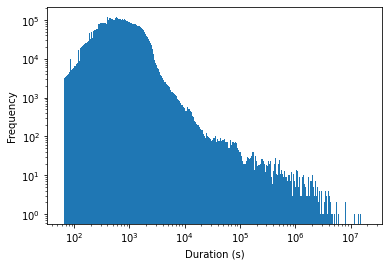

In [16]:
min_dur = data["tripduration"].min()
max_dur = data["tripduration"].max()
n_bins = 1000
bins = np.logspace(start = np.log10(min_dur),stop = np.log10(max_dur),num=n_bins)
ax = data["tripduration"].plot(kind="hist",loglog=True,bins=bins)
ax.set_xlabel("Duration (s)")

Most trips are between 2 mins and 1 hour.
We remove trip durations > 5 hours ($\approx 2\cdot10^4$ s), since these seem unlikely inside New York.
Also note that durations < 60 seconds were already removed by the data provider, reasoning that these are likely just people trying to redock the bike.

In [17]:
duration_h = 5
longtrips = data[data["tripduration"] >= duration_h*60*60]
print(f"There are {len(longtrips)} trips of at least {duration_h} hours in the data.")
data.drop(longtrips.index,inplace=True)

There are 15454 trips of at least 5 hours in the data.


We also notice that there are round trips in the data.

There are 345517 round trips in the data


Text(0.5, 0, 'Duration (min)')

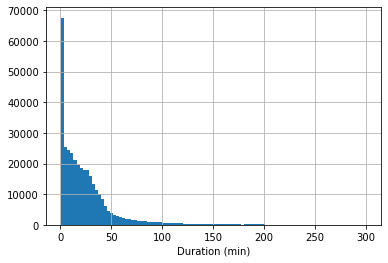

In [18]:
roundtrips = data[data["start station id"] == data["end station id"]]
print(f"There are {len(roundtrips)} round trips in the data")
ax = (roundtrips["tripduration"] / 60).hist(bins=100)
ax.set_xlabel("Duration (min)")

Text(0.5, 0, 'Duration (s)')

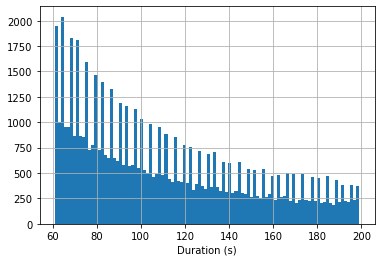

In [19]:
ax = roundtrips[roundtrips["tripduration"]<200]["tripduration"].hist(bins=100)
ax.set_xlabel("Duration (s)")

Let us also exlcude round trips of less than 120 seconds, since these also seem like people docking their bike.

In [20]:
shortroundtrips = roundtrips[roundtrips["tripduration"]<120]
print(f"There are {len(shortroundtrips)} short round trips in the data")
data.drop(shortroundtrips.index,inplace=True)

There are 38770 short round trips in the data


Let us furthermore indicate which trips are round trips for convenience

In [45]:
data["is_roundtrip"] = data["start station id"] == data["end station id"]
data["is_roundtrip"].value_counts()

False    17184871
True       306747
Name: is_roundtrip, dtype: Int64

In [24]:
data["roundtrip"] = data["start station id"] == data["end station id"]
data["roundtrip"].value_counts()

False    17184871
True       306747
Name: roundtrip, dtype: Int64

## Birthyears

Next, we look at the distribution of birth years

Next, lets have a look at the birthyears.

In [46]:
print(data["birth year"].min())
print(data["birth year"].max())

1885
2002


Since the data is from 2018, we exclude people born before 1920.

We will exclude people born before 1920, since the data is from 2018.

In [25]:
old = data[data["birth year"] <= 1920]
print(f"There are {len(old)} trips made by people born before 1920 in the data.")
data.drop(old.index,inplace=True)

There are 11337 trips made by people born before 1920 in the data.


## Coordinates

Next, we look at the coordinates. New york encompasses latitudes of about between 40.6 and 40.9, and longitudes between -74.2 and -73.7

Next, we look at the coordinates.
New york encompasses latitudes of about between 40.6 and 40.9, and longitudes between -74.2 and -73.7

In [26]:
print(data["start station latitude"].min())
print(data["start station latitude"].max())

40.64653836709648
45.506364054011385


Text(0.5, 0, 'Latitude')

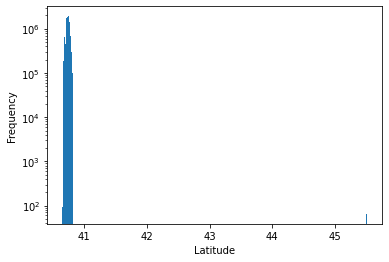

In [27]:
ax = data["start station latitude"].plot(kind="hist",logy = True,bins=600)
ax.set_xlabel("Latitude")

There appear to be around a 50 bikes lost at latitude > 45, which is somewhere around Montreal.
We exclude these.

In [28]:
lost = data[data["start station latitude"]>41]
print(len(lost))
data.drop(lost.index,inplace=True)

65


The remaining values make sense:

In [29]:
min_lat = data[["start station latitude","end station latitude"]].min().min()
max_lat = data[["start station latitude","end station latitude"]].max().max()
min_long = data[["start station longitude","end station longitude"]].min().min()
max_long = data[["start station longitude","end station longitude"]].max().max()
print(f"The latitude is between {min_lat:.2f} and {max_lat:.2f}")
print(f"The longitude is between {min_long:.2f} and {max_long:.2f}")

The latitude is between 40.65 and 40.81
The longitude is between -74.08 and -73.91


We save cleaned data for later convenience.

In [30]:
data.to_csv(savepath,index=False)

## Computing some more features

In [9]:
data = load_data(savepath)

There are some features that seem intuitively obvious to compute, such as the distane traveled, the speed of the bikes, whether it is a workday or weekend, and whether it is summer or winter.
We do this for the whole data set.
Note that we do not use any information about the labels here, so we do not need a train / test split yet.

### Distance

Compute Haversine distance between start and end point

In [31]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Taken from https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas
    
    Calculate the great circle distance in meters between two points
    on the earth (which are specified in decimal degrees)

    All args must be of equal length.    
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    m = (6367 * c)*1000
    return m

In [32]:
haversine(data.iloc[0]["start station longitude"], data.iloc[0]["start station latitude"], data.iloc[0]["end station longitude"], data.iloc[0]["end station latitude"])
#quick sanity check, google maps claims a distance of about 850 m between these station

820.1532646056683

In [33]:
data["haversine distance"] = haversine(data["start station longitude"], data["start station latitude"], data["end station longitude"], data["end station latitude"])

In [14]:
data["speed"] = (data["haversine distance"]/1000) / (data["tripduration"]/3600) #Estimated speed in kmh

This will generally underestimate the speed because we are using haversine and not routing distance.
Since the distance in new york is given roughly by 1-norm, and haversine is 2-norm distance, the underestimate is roughly by a factor $\sqrt(2)$.
We see that some data points have irregular speeds over 40 kmh, and we remove these.

In [ ]:
fast = data[data["speed"]>40]
print(f"There are {len(fast)} short round trips in the data")
data.drop(fast.index,inplace=True)
data.to_csv(savepath,index=False)

### Some information about weekday and holiday

We will also collect some information on weekdays and holidays vs business days

In [34]:
data["weekday"] = data["starttime"].dt.dayofweek

In [35]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2018-01-01', end='2018-12-31')
isholiday = data["starttime"].dt.date.astype("datetime64").isin(holidays)

In [36]:
data["holiday"] = isholiday
data["holiday"].value_counts()

False    17152317
True       327899
Name: holiday, dtype: int64

In [38]:
data["business day"] = (data["weekday"] < 5) & (~data["holiday"])
data["business day"].value_counts()

True     12938644
False     4541572
Name: business day, dtype: int64

In [64]:
#Check the number of different business days. There should be 251 for 2018.
n_businessday = data[data["business day"]]["starttime"].dt.date.nunique()
print(f"There are {n_businessday} business days.")

There are 251 business days.


In [40]:
data.to_csv(savepath,index=False)

In [41]:
print_memory_usage(data)

The dataframe needs 2.31 GB of memory


## Unsupervised Analysis

We will now examine some properties of the data and try to find interesing patterns.
Since we examine the entire data set, we will be careful not to make use of the labels.

In [43]:
unlabeled = data.drop("usertype",axis=1)

First, lets look at the distribution of trips over the year

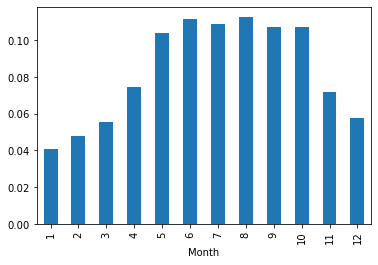

In [63]:
countbymonth = unlabeled.groupby(by = unlabeled["starttime"].dt.month).size() / len(unlabeled)
countbymonth.index.name = "Month"
ax = countbymonth.plot.bar()

We see that there is a lot more traffic during the summer month.
This might also suggest a feature "summer", which is true during the month 5-10.

In [12]:
data["summer"] = (data["starttime"].dt.month >=5) & (data["starttime"].dt.month <=10)

Let us also look at the distribution over weekday.

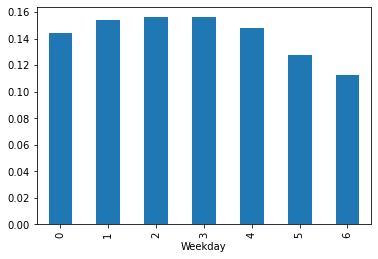

In [76]:
weekday_group = unlabeled.groupby(by = unlabeled["starttime"].dt.dayofweek)
countbyweekday = weekday_group.size() / len(unlabeled)
countbyweekday.index.name = "Weekday"
ax = countbyweekday.plot.bar()

There appears to be more traffic during the week than on weekends. We will later look at how this differs between Subscribers and Customers. However, people do appear to take longer trips on weekends, as seen in the following graph.

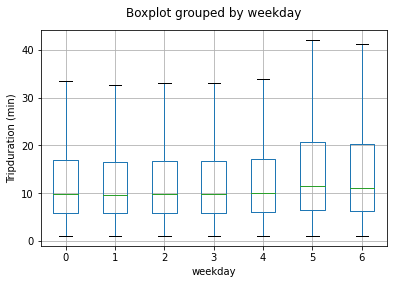

In [96]:
unlabeled["tripduration (min)"] = unlabeled["tripduration"] / 60
ax = unlabeled.boxplot(column="tripduration (min)",by="weekday",showfliers=False)
ax.set_title("")
_ = ax.set_ylabel("Tripduration (min)")
unlabeled.drop("tripduration (min)",axis=1,inplace=True)

Now, we look at the distribution of trips on holidays vs business days

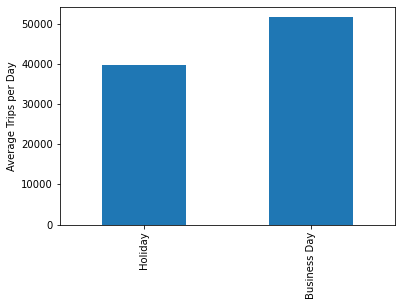

In [97]:
countbybusinessday = unlabeled.groupby(by = [unlabeled["business day"],unlabeled["starttime"].dt.date]).size()
averagetrips = countbybusinessday.groupby(level=0).mean()
ax = averagetrips.plot.bar()
ax.set_ylabel("Average Trips per Day")
ax.set_xlabel("")
_ = ax.set_xticklabels(["Holiday", "Business Day"])

We see that there is also more traffic on business days than holidays. Again, this might differ between subscribers and customers.

In [15]:
data.to_csv(savepath,index=False)

In [16]:
del data

# Splitting the Data

We now split the data into training/validation/test.
Since we have a lot of data we will not use resampling methods such as bootstrap or cross-validation and go with a traditional split.

In [107]:
print(len(data))
n = len(data)
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1
train_size = int(train_ratio*n)
val_size = int(val_ratio*n)
test_size = int(test_ratio*n)
print("Train: {0}, Val: {1}, Test: {2}".format(int(train_ratio*n), int(val_ratio*n), int(test_ratio*n)))

17480216
Train: 13984172, Val: 1748021, Test: 1748021


Let us consider how accurate our estimate of the model accuracy will be, on the test set.
We assume that we want accuracy per class, and since the data set is very unbalanced we can only use about $10\%$ of the test set for the estimate on the rare class.
Lets say we get a true model accuracy of $99\%$.

In [111]:
f"The standard error of the estimated accuracy will be {np.sqrt(0.01*0.99 / (test_size/10)):2f}"

'The standard error of the estimated accuracy will be 0.000238'

In [112]:
#This is memory intensive, if there are problems we could do it inplace by just computing indices for train/val/test
trainset,testset = train_test_split(data,test_size=test_size)
trainset,valset = train_test_split(trainset,test_size=val_size)
print(len(trainset),len(valset),len(testset))

13984174 1748021 1748021


In [113]:
with open("Data/Train.csv","w") as file:
    trainset.to_csv(file,index=False)

In [114]:
with open("Data/Validation.csv","w") as file:
    valset.to_csv(file,index=False)

In [115]:
with open("Data/Test.csv","w") as file:
    testset.to_csv(file,index=False)